In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import norm
import tqdm
import time

np.random.seed(42)

## Implement logistic regression from scratch.


$$\textrm{log-likelihood, }\ell(\theta) = \log L(\theta) = \sum_{i=1}^n \left[ y^{(i)} \log h_\theta(x^{(i)}) + (1 - y^{(i)}) \log (1 - h_\theta(x^{(i)})) \right]$$

$$ \mathbf{\implies \ell(\theta)} = \mathbf{Y}.log(\mathbf{h_\theta(X)}) + (1 - \mathbf{Y}). log(\mathbf{1 - h_\theta(X)}) $$


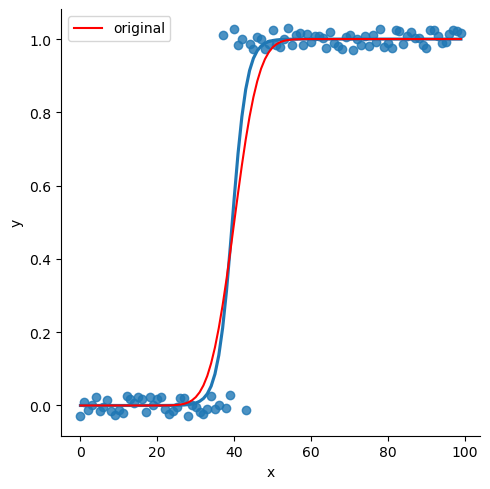

In [113]:
# for simplicity the dimensions of the data , X is 100, 1 only

# creating custom binary classification data
data_x = np.arange(0, 100)

# using the gaussian cdf to generate desired probabilities
probabilities = norm.cdf(data_x, loc=40, scale=5)
random_vals = np.random.random(data_x.shape)

data_y = np.where(random_vals < probabilities, 1, 0)

df = pd.DataFrame({'x': data_x, 'y': data_y})
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, probabilities, color='red', label='original')
plt.legend()

In [114]:
# intial theta
# theta_initial = np.array([-10, -60], dtype='float64')
theta_initial = np.array([0, 0], dtype='float64')

# writing the function to be maximised
def sigmoid(x):
    return 1/(1 + np.exp(-x))

def create_h_arr(x, theta):
    x_ = np.column_stack([x, np.ones(x.shape[0])])
    h = sigmoid(np.dot(x_, theta))
    epsilon = 1e-8
    return np.clip(h, epsilon, 1-epsilon)

# create_h_arr(data_x, theta_initial)

In [115]:
# define the log likelihood function

def log_likelihood_fn(theta, x, y):
    h_array = create_h_arr(x, theta)
    log_likelihood = y.dot(np.log(h_array)) + (1-y).dot(np.log(1-h_array))
    
    return log_likelihood


for gradient ascent
$$ \theta : = \theta + \alpha \nabla_\theta \ell (\theta )$$
for stochastic gradient ascent
$$ \theta_j : = \theta_j + \alpha \big( y^{(i)} - h(x^{(i)}) \big)x_j^{(i)} $$

where $\alpha$ is the learning rate
$\theta$ in our case is of dimensions $(2,1)$

In [116]:
# class of all optimizers

class optimize:
    def __init__(self, x, y):
        """
        x and y should be 1d array of same size
        """
        self.x = x
        self.y = y
        self.X = np.column_stack([self.x, np.ones(self.x.shape[0])])

    def calculate_gradient(self, theta):
        """
        calculate gradient for 1 training example
        """
        
        h = create_h_arr(self.x, theta)
        grad = np.dot((self.y-h), self.x)

        return grad
    
    def fisher_update(self, theta, alpha, epsilon=1e-8):
        p = np.vectorize(sigmoid)(self.X.dot(theta))
        w = np.multiply(p, 1-p)
        
        W = np.diag(np.clip(w, epsilon, None))

        z = self.X.dot(theta) + alpha * np.linalg.inv(W).dot(self.y - p)
        return np.linalg.inv(self.X.T @ W @ self.X) @ self.X.T @ W @ z
        

    def batch_gradient_ascent(self, theta_initial, learning_rate, epochs, verbose=False):
        t0 = time.time()
        theta = theta_initial.copy()

        # storing history for displaying graph
        history_theta = np.zeros((epochs+1, theta.shape[0]))
        history_theta[0] = theta

        history_loss = np.zeros(epochs+1,)
        history_loss[0] = self.calculate_mse(theta)

        for epoch in range(epochs):
            theta += learning_rate * self.calculate_gradient(theta)
            
            history_theta[epoch+1] = theta
            history_loss[epoch+1] = self.calculate_mse(theta)
            
            if verbose:
                print(f"epoch {epoch} -> theta: {theta}")
        
        print(f'done in {time.time() - t0:.2f}s')
        return {'theta': theta, 'history_theta': history_theta, 'epochs': epochs, 'history_loss': history_loss}
    

    def fisher_scoring(self, theta_initial, learning_rate, epochs, verbose=False):
        t0 = time.time()
        theta = theta_initial.copy()
        
        # storing history
        history_theta = np.zeros((epochs+1, theta.shape[0]))
        history_theta[0] = theta
        history_loss = np.zeros(epochs+1,)
        history_loss[0] = self.calculate_mse(theta)

        for epoch in range(epochs):
            theta = self.fisher_update(theta, learning_rate)
            
            history_theta[epoch+1] = theta
            history_loss[epoch+1] = self.calculate_mse(theta)

            if verbose:
                print(f"epoch {epoch} -> theta: {theta}")

        print(f'done in {time.time() - t0:.2f}s')
        return {'theta': theta, 'history_theta': history_theta, 'history_loss': history_loss, 'epochs': epochs}

    
    def calculate_mse(self, theta):
        loss_arr = np.square(self.y - np.around(create_h_arr(self.x, theta)))

        return loss_arr.sum()/loss_arr.shape[0]

In [129]:
optimizer = optimize(data_x, data_y)

bgd = optimizer.batch_gradient_ascent(theta_initial, learning_rate=1e-7, epochs=10000)

done in 1.22s


Text(0.5, 1.0, 'loss')

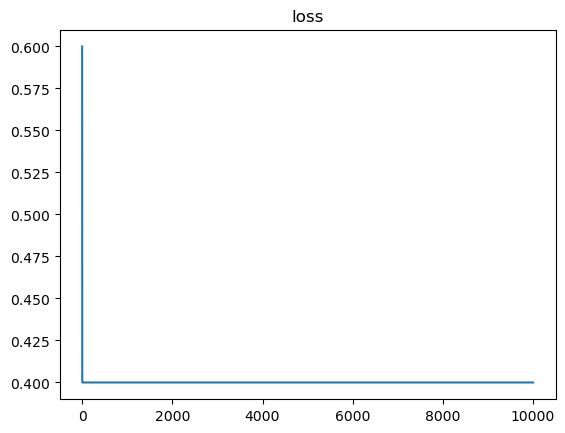

In [130]:
plt.plot(bgd['history_loss'])
plt.title('loss')

Text(0.5, 1.0, 'prediction')

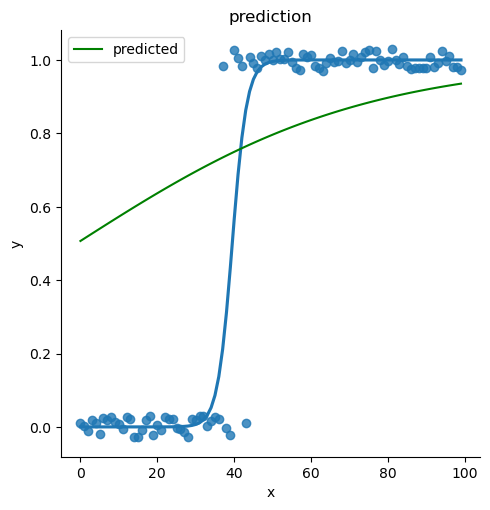

In [131]:
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, create_h_arr(data_x, bgd['theta']), color='green', label='predicted')
plt.legend()
plt.title('prediction')

Text(0, 0.5, 'theta1(intercept)')

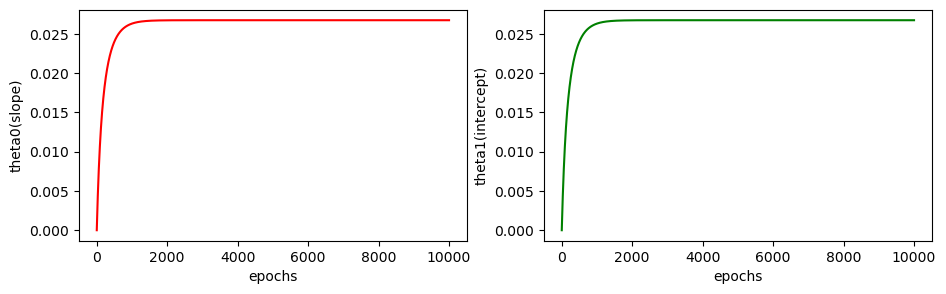

In [132]:
plt.figure(figsize=(11, 3))
plt.subplot(1,2,1)
plt.plot(bgd['history_theta'][:, 0], color='red')
plt.xlabel('epochs')
plt.ylabel('theta0(slope)')


plt.subplot(1,2,2)
plt.plot(bgd['history_theta'][:, 1], color='green')
plt.xlabel('epochs')
plt.ylabel('theta1(intercept)')

In [111]:
fisher = optimizer.fisher_scoring(theta_initial, learning_rate=1e-5, epochs=10000)

C:\Users\msing\AppData\Local\Temp\ipykernel_8536\3399019405.py:7: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))


done in 7.66s


Text(0.5, 1.0, 'loss')

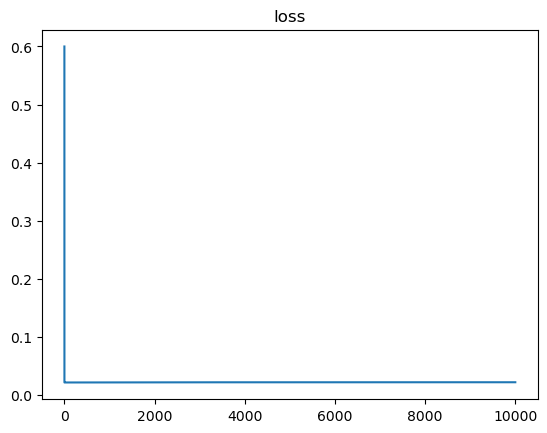

In [103]:
plt.plot(fisher['history_loss'])
plt.title('loss')

Text(0.5, 1.0, 'prediction')

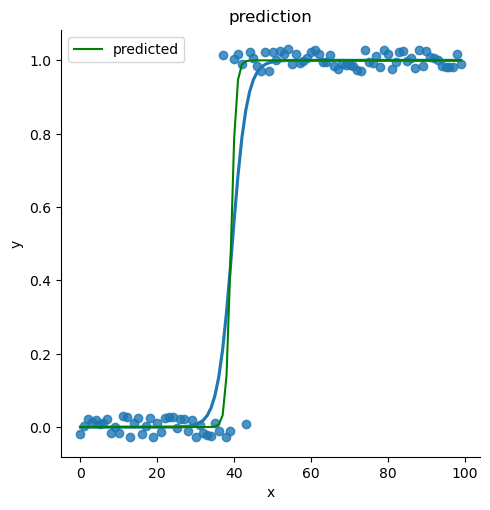

In [104]:
sns.lmplot(x="x", y="y", data=df, logistic=True, ci=None, y_jitter=0.03)
plt.plot(data_x, create_h_arr(data_x, fisher['theta']), color='green', label='predicted')
plt.legend()
plt.title('prediction')

Text(0, 0.5, 'theta1(intercept)')

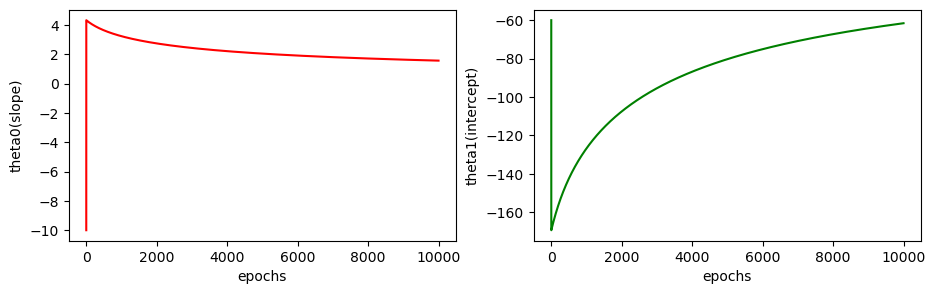

In [105]:
plt.figure(figsize=(11, 3))
plt.subplot(1,2,1)
plt.plot(fisher['history_theta'][:, 0], color='red')
plt.xlabel('epochs')
plt.ylabel('theta0(slope)')


plt.subplot(1,2,2)
plt.plot(fisher['history_theta'][:, 1], color='green')
plt.xlabel('epochs')
plt.ylabel('theta1(intercept)')